In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

batch_size = 10
learning_rate = 0.0001
epoch = 20

n_node = 1024
drop_ratio = 0.5

img_size = 256

In [16]:
img_dir = 'animal/train'
train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(img_size*2),
    transforms.RandomCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(img_size),
    transforms.ToTensor()
]))

print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

46


In [17]:
img_dir='animal/val'
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.Resize(img_size),
    transforms.ToTensor()
]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [18]:
img_dir = 'animal/test'
test_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.Resize(img_size),
    transforms.ToTensor()
]))
test_batch = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

# of classes : 2
['cats', 'dogs']
{'cats': 0, 'dogs': 1}
46
Training: 46, Dev: 17, Test: 41


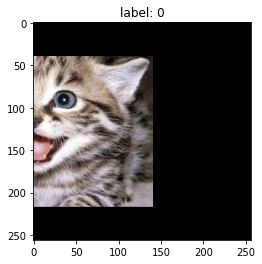

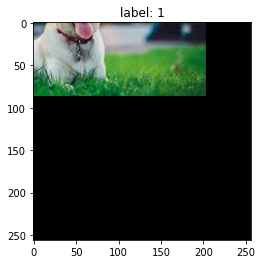

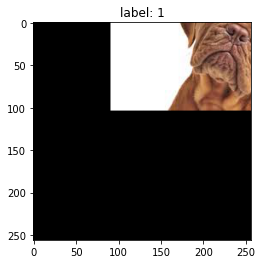

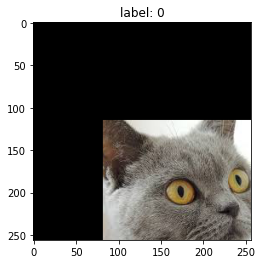

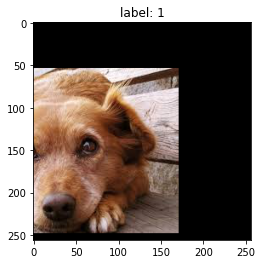

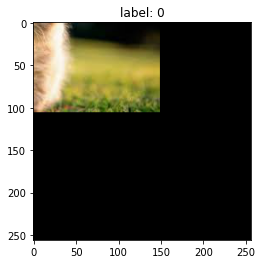

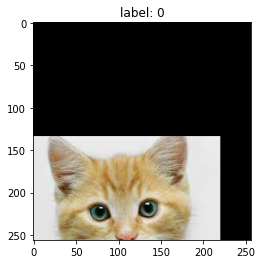

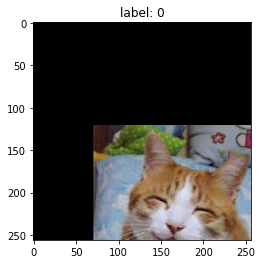

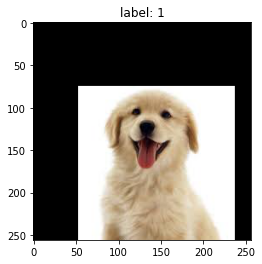

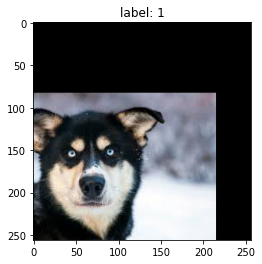

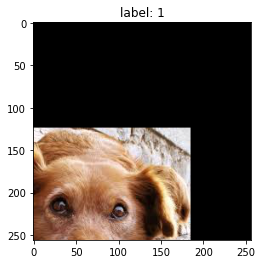

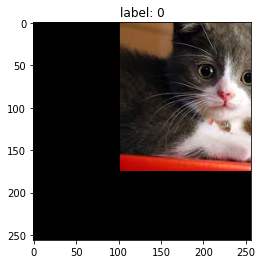

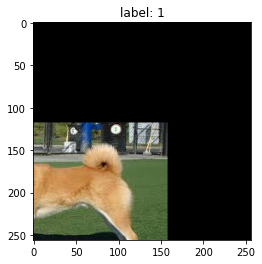

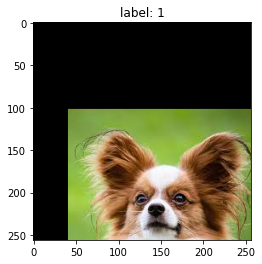

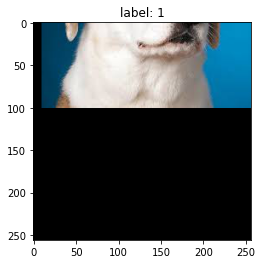

In [19]:
nclass = len(train_data.classes)
print('# of classes : %d' %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print('Training: %d, Dev: %d, Test: %d' %(train_data.__len__(), dev_data.__len__(),test_data.__len__()))

for imgs, labels in train_batch:
    for j in range(3):
        img = transforms.ToPILImage()(imgs[j])
        plt.title('label: %d' %(labels[j]))
        plt.imshow(img)
        plt.show()

In [20]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['cats', 'dogs']
['cats', 'dogs']
['cats', 'dogs']


In [21]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
    print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])


features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [22]:
base_dim = 64
fsize = img_size//32

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])

        self.layer1 = nn.Sequential(
            nn.Linear(8 * base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(drop_ratio),

            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(drop_ratio),

            nn.Linear(n_node,n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(drop_ratio),

            nn.Linear(n_node, nclass)
        )

        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self,x):
        #layer 0의 사이즈 알아내기 보통 (batch_size, x, x, x)
        #print(x.size())
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)

        return out

In [29]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad= False

for params in model.layer1.parameters():
    params.required_grad = True

for name in model.children():
    print(name)

RuntimeError: CUDA error: out of memory

In [11]:
import torch.nn.functional as F
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

total_time = 0
disp_step = 10

to_train = True
if(to_train==False):
    netname = './nets/catdog_vgg19_10.pkl'
    model = torch.load(netname)
else:
    print('3 layer, n_node: %d, dropratio: %.2f' %(n_node, drop_ratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)

    print('Correct of train: %.2f, dev: %.2f, test: %.2f' %(train_corr, dev_corr, test_corr))
    model.train()

    netname='./nets/catdog_vgg19'

    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []

    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)

    for i in range(epoch):
        start_time = time.time()
        print('%d..' %i, end='')
        for img,label in train_batch:
            img = Variable(img)
            label = Variable(label)

            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time+=duration
        if (i % disp_step==0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl' %i)
            print('\n[%d/%d] loss:%.3f,' %(i, epoch, (loss.cpu()).data.numpy()))

            model.eval()

            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print('Correct of train: %.2f, dev: %.2f, test: %.2f' %(train_corr, dev_corr, test_corr))
            model.train()
            print('time: %.2f sec..' %(total_time))

            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print('Total time: %.2f sec' %(total_time))

3 layer, n_node: 1024, dropratio: 0.50
0..
[0/20] loss:1.563,
time: 14.11 sec..
1..tensor([0.9863, 0.0137])


KeyboardInterrupt: 

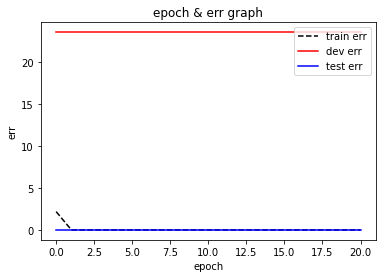

In [50]:
if(to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')

    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc='upper right')

    plt.show()

Normalized confusion matrix


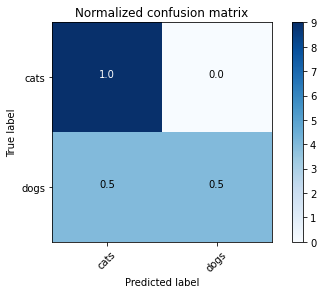

Confusion matrix, without normalization


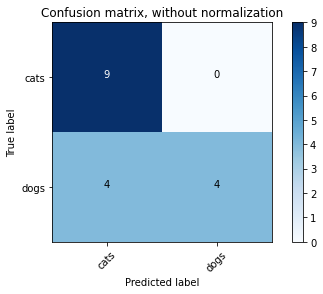

	 acc  |	 pre  |	 rec  |	 f1
 cats: 0.76 |	 0.69 |	 1.00 |	 0.82
 dogs: 0.76 |	 1.00 |	 0.50 |	 0.67
*accuracy: 0.76, precision: 0.85, recall: 0.75, *f1 score: 0.74
[AP]
cats: 0.90
dogs: 0.86

[mAP] 0.883
[miAP] 0.882


(array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1]),
 array([0.99988031, 0.99961025, 0.65857708, 0.90842617, 0.80662668,
        0.66691709, 0.99713576, 0.99843651, 0.55624026, 0.99969679,
        0.88990098, 0.9867928 , 0.73338634, 0.84684473, 0.99326164,
        0.99512231, 0.66695869]))

In [52]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Category: cats
 True predicted images/total cats category: 9 / 9
Predicted probability:
[0.9867928  0.01320718]


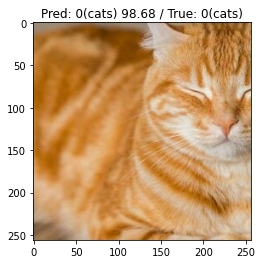

Predicted probability:
[0.6585771  0.34142295]


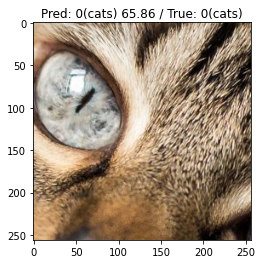

 False predicted images/total cats category: 0 / 9
Category: dogs
 True predicted images/total dogs category: 4 / 8
Predicted probability:
[0.00286425 0.99713576]


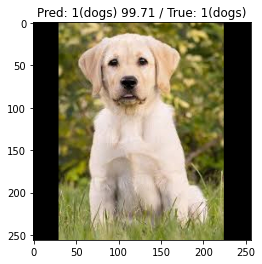

Predicted probability:
[0.00673838 0.99326164]


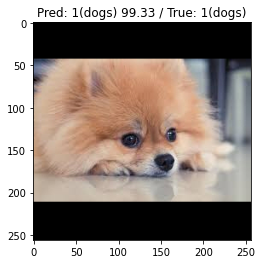

 False predicted images/total dogs category: 4 / 8
Predicted probability:
[0.84684473 0.15315527]


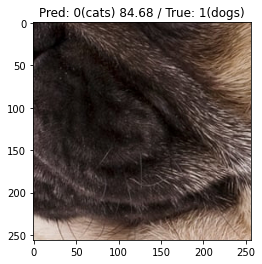

Predicted probability:
[0.66695875 0.33304128]


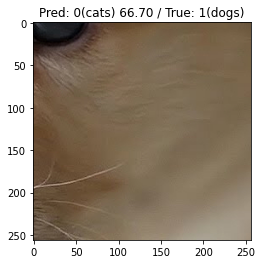

In [53]:
utils.VisTFPred(dev_batch, model, dev_data.classes, batch_size, i_n=2)